# Import Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, recall_score, precision_score,
    f1_score, accuracy_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import clang.cindex
import os
import numpy as np
import re
import pickle
import warnings

pd.set_option('display.max_colwidth', None)
# Ignore all warnings
warnings.filterwarnings('ignore')


# Prepare and Save Dataset

This code performs the following steps:

1. **Define Paths**:
   - `non_defective_path` and `defective_path` specify the directories containing non-defective and defective text files, respectively.

2. **Initialize Lists**:
   - `file_paths`: List to hold the file paths of the text files.
   - `original_code`: # Column for original code before preprocessing 'with out removed comments'.
   - `processed_code`: # Column for processed code after preprocessing 'with removed comments'.
   - `labels`: List to hold the corresponding labels (1 for non-defective and 0 for defective).

3. **Read Non-Defective Files**:
   - Iterates through files in the `non_defective_path` directory. If a file ends with `.txt`, its path is added to `file_paths`, and the label `1` (indicating non-defective) is appended to `labels`.

4. **Read Defective Files**:
   - Similarly, iterates through files in the `defective_path` directory. If a file ends with `.txt`, its path is added to `file_paths`, and the label `0` (indicating defective) is appended to `labels`.

5. **Create a DataFrame**:
   - Constructs a Pandas DataFrame using the `file_paths`, `original_code`, `processed_code` and `labels` lists.

6. **Save DataFrame to CSV**:
   - Saves the DataFrame as a CSV file named `data.csv` in the `/content/` directory.

7. **Print Confirmation**:
   - Outputs a message indicating that the DataFrame has been created and saved successfully.


In [2]:

# # Function to remove comments from C++ code
# def remove_comments(code):
#     # Remove single-line comments
#     code = re.sub(r'//.*', '', code)
#     # Remove multi-line comments
#     code = re.sub(r'/\*[\s\S]*?\*/', '', code)
#     return code

# # Define paths to the directories containing text files
# non_defective_path = r'/content/Final_data/non-defective'  # Directory path for non-defective files
# defective_path = r'/content/Final_data/defective'  # Directory path for defective files

# # Initialize lists to store file paths, processed code, and their corresponding labels
# file_paths = []  # List to store paths of text files
# original_code = []  # List to store original code from files
# processed_code = []  # List to store processed code after removing comments
# labels = []  # List to store labels (1 for non-defective, 0 for defective)

# # Function to read and process files from a given directory
# def read_and_process_files(directory_path, label):
#     for filename in os.listdir(directory_path):
#         if filename.endswith('.txt'):  # Check if the file is a text file
#             file_path = os.path.join(directory_path, filename)
#             with open(file_path, 'r', encoding='utf-8') as file:
#                 code = file.read()
#                 code_without_comments = remove_comments(code)
#                 file_paths.append(file_path)  # Add the file path to the list
#                 original_code.append(code)  # Add the original code to the list
#                 processed_code.append(code_without_comments)  # Add the processed code to the list
#                 labels.append(label)  # Add the corresponding label

# # Read and process files from the non-defective directory
# read_and_process_files(non_defective_path, 1)  # Label 1 for non-defective

# # Read and process files from the defective directory
# read_and_process_files(defective_path, 0)  # Label 0 for defective

# # Create a Pandas DataFrame with file paths, original code, processed code, and labels
# df = pd.DataFrame({
#     'file_path': file_paths,  # Column for file paths
#     'original_code': original_code,  # Column for original code
#     'processed_code': processed_code,  # Column for processed code
#     'label': labels  # Column for labels
# })


# Preprocessing C++ Code for Token Extraction using Clang and Regular Expressions

This script demonstrates two approaches to extract tokens from C++ code: using the Clang library and regular expressions. The extracted tokens are stored in a DataFrame, which is then saved as a CSV file.

### Key Functions:
1. **Clang Token Extraction (`extract_clang_tokens`)**:
   - Leverages the Clang library to parse C++ code into an abstract syntax tree (AST) and extract tokens.
   - Uses the Clang `cindex` module to parse the code and return a space-separated string of tokens.

2. **C++ Token Extraction with Regular Expressions (`extract_cpp_tokens`)**:
   - Applies regex patterns to identify C++ keywords, identifiers, operators, and literals from the code.
   - Extracts tokens and returns them in a space-separated string.

The DataFrame is updated with two columns: `clang_tokens` and `cpp_tokens`, containing the respective token outputs from each approach. The final DataFrame is saved as `data.csv`.


In [3]:
# # Function to extract tokens from C++ code using Clang
# def extract_clang_tokens(code_str):
#     # Initialize Clang index
#     index = clang.cindex.Index.create()

#     # Create a Clang translation unit from the code
#     tu = index.parse('temp.cpp', unsaved_files=[('temp.cpp', code_str)], args=['-std=c++11'])

#     # Extract tokens from the AST
#     tokens = []
#     for token in tu.get_tokens(extent=tu.cursor.extent):
#         tokens.append(token.spelling)

#     return ' '.join(tokens)

# # Apply the Clang token extraction to the processed_code column
# df['clang_tokens'] = df['processed_code'].apply(extract_clang_tokens)

# # Function to extract basic C++ tokens using regular expressions
# def extract_cpp_tokens(code_str):
#     # Regular expressions to capture C++ keywords, identifiers, operators, and literals
#     token_pattern = r'[a-zA-Z_]\w*|[{}()\[\];,]|[<>!=]=|==|&&|\|\||[-+*/%^&|!<>]=?|::|->|\.|\d+'

#     # Extract tokens using regex
#     tokens = re.findall(token_pattern, code_str)

#     # Return tokens as a space-separated string
#     return ' '.join(tokens)

# # Apply token extraction to the processed_code column
# df['cpp_tokens'] = df['processed_code'].apply(extract_cpp_tokens)

# # Save the DataFrame to a CSV file
# df.to_csv('data.csv', index=False)  # Save DataFrame without row indices

# # Print confirmation message
# print("DataFrame created and saved as 'data.csv'.")

# # Display the first few rows with the extracted tokens
# df.head()


# Show DataFrame

In [4]:
# Load the DataFrame
df = pd.read_csv('data.csv').dropna()

df.head()

,file_path,original_code,processed_code,label,clang_tokens,cpp_tokens
0,/content/Final_data/non-defective/584.txt,"#include <mpi.h>\n#include <omp.h>\n#include <iostream>\n\nint main(int argc, char** argv) {\n // ... (MPI Initialization)\n\n int data[10];\n int sum = 0;\n #pragma omp parallel num_threads(2)\n {\n #pragma omp for reduction(+:sum)\n for (int i = 0; i < 10; i++) {\n sum += data[i]; \n }\n }\n MPI_Send(&sum, 1, MPI_INT, 0, 0, MPI_COMM_WORLD); // Send after reduction is guaranteed complete\n \n // ... (MPI Finalization)\n return 0;\n}\n","#include <mpi.h>\n#include <omp.h>\n#include <iostream>\n\nint main(int argc, char** argv) {\n \n\n int data[10];\n int sum = 0;\n #pragma omp parallel num_threads(2)\n {\n #pragma omp for reduction(+:sum)\n for (int i = 0; i < 10; i++) {\n sum += data[i]; \n }\n }\n MPI_Send(&sum, 1, MPI_INT, 0, 0, MPI_COMM_WORLD); \n \n \n return 0;\n}\n",1,"# include < mpi . h > # include < omp . h > # include < iostream > int main ( int argc , char * * argv ) { int data [ 10 ] ; int sum = 0 ; # pragma omp parallel num_threads ( 2 ) { # pragma omp for reduction ( + : sum ) for ( int i = 0 ; i < 10 ; i ++ ) { sum += data [ i ] ; } } MPI_Send ( & sum , 1 , MPI_INT , 0 , 0 , MPI_COMM_WORLD ) ; return 0 ; }","include < mpi . h > include < omp . h > include < iostream > int main ( int argc , char * * argv ) { int data [ 10 ] ; int sum 0 ; pragma omp parallel num_threads ( 2 ) { pragma omp for reduction ( + sum ) for ( int i 0 ; i < 10 ; i + + ) { sum += data [ i ] ; } } MPI_Send ( & sum , 1 , MPI_INT , 0 , 0 , MPI_COMM_WORLD ) ; return 0 ; }"
1,/content/Final_data/non-defective/125.txt,"int main(int argc, char **argv) {\n int comm_size, comm_rank;\n MPI_Init(&argc, &argv);\n MPI_Comm_size(MPI_COMM_WORLD, &comm_size);\n MPI_Comm_rank(MPI_COMM_WORLD, &comm_rank);\n std::vector<double> x(10000000, 1.0);\n std::vector<double> y(10000000, 1.0);\n double local_sum = 0.0;\n #pragma omp parallel\n {\n int num_threads = omp_get_num_threads();\n int thread_id = omp_get_thread_num();\n int chunk_size = x.size() / num_threads;\n int start = thread_id * chunk_size;\n int end = std::min(start + chunk_size, int(x.size()));\n double local_dot = 0.0;\n for (int i = start; i < end; i++) {\n local_dot += x[i] * y[i];\n }\n #pragma omp barrier\n #pragma omp critical\n {\n local_sum += local_dot;\n }\n #pragma omp barrier\n MPI_Allreduce(MPI_IN_PLACE, &local_sum, 1, MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD);\n }\n std::cout << ""Rank "" << comm_rank << "": Dot Product = "" << local_sum << std::endl;\n MPI_Finalize();\n return 0;\n}\n","int main(int argc, char **argv) {\n int comm_size, comm_rank;\n MPI_Init(&argc, &argv);\n MPI_Comm_size(MPI_COMM_WORLD, &comm_size);\n MPI_Comm_rank(MPI_COMM_WORLD, &comm_rank);\n std::vector<double> x(10000000, 1.0);\n std::vector<double> y(10000000, 1.0);\n double local_sum = 0.0;\n #pragma omp parallel\n {\n int num_threads = omp_get_num_threads();\n int thread_id = omp_get_thread_num();\n int chunk_size = x.size() / num_threads;\n int start = thread_id * chunk_size;\n int end = std::min(start + chunk_size, int(x.size()));\n double local_dot = 0.0;\n for (int i = start; i < end; i++) {\n local_dot += x[i] * y[i];\n }\n #pragma omp barrier\n #pragma omp critical\n {\n local_sum += local_dot;\n }\n #pragma omp barrier\n MPI_Allreduce(MPI_IN_PLACE, &local_sum, 1, MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD);\n }\n std::cout << ""Rank "" << comm_rank << "": Dot Product = "" << local_sum << std::endl;\n MPI_Finalize();\n return 0;\n}\n",1,"int main ( int argc , char * * argv ) { int comm_size , comm_rank ; MPI_Init ( & argc , & argv ) ; MPI_Comm_size ( MPI_COMM_WORLD , & comm_size ) ; MPI_Comm_rank ( MPI_COMM_WORLD , & comm_rank ) ; std :: vector < double > x ( 10000000 , 1.0 ) ; std :: vector < double > y ( 10000000 , 1.0 ) ; double local_sum = 0.0 ; # pragma omp parallel { int num_threads = omp_get_num_threads ( ) ; int thread_id = omp_get_thread_num ( ) ; int chunk_size = x . size ( ) / num_threads ;

# Display Label Distribution

In [5]:
# This provides a summary of how many samples belong to each class (defective and non-defective).
df.label.value_counts()

,count
label,
1,756
0,752


## Text Tokenization and Preprocessing for Model Input

This code snippet prepares textual data for input into a machine learning model by performing the following steps:

1. **Parameter Initialization**:
   - `max_features`: Limits the number of unique words to be considered as features (5000 in this case).
   - `max_len`: Specifies the maximum sequence length for input data, truncating or padding sequences as needed (1024 words).

2. **Tokenization**:
   - A `Tokenizer` object is created to convert the text data into sequences of integers, where each integer represents a word's index in the vocabulary.
   - The tokenizer is fitted on the `processed_code` column of the DataFrame `df` to learn the vocabulary.

3. **Text to Sequence Conversion**:
   - The text data is transformed into sequences of integers using the tokenizer.

4. **Padding Sequences**:
   - The sequences are padded to ensure they all have the same length (`max_len`), making them suitable for input into models that require fixed-length sequences.

5. **Label Extraction**:
   - The target labels (`y`) are extracted from the DataFrame for use in model training.

6. **Saving the Tokenizer**:
   - The fitted tokenizer is saved to a file (`tokenizer.pkl`) using the `pickle` module, allowing it to be reused for preprocessing new data during inference.


In [6]:
# Parameters
max_features = 5000  # Number of words to consider as features
max_len = 1024  # Cut texts after this number of words (max length) Num of Features

# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['cpp_tokens'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['cpp_tokens'])

# Pad sequences to ensure uniform input length
x = pad_sequences(sequences, maxlen=max_len)

# Labels
y = df['label'].values

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

## Data Splitting and Shape Overview

This code snippet splits the preprocessed data into training and testing sets, and then prints out the shapes of these sets:

1. **Data Splitting**:
   - The `train_test_split` function is used to divide the dataset into training and testing sets.
   - `x` (features) and `y` (labels) are split such that 10% of the data is reserved for testing (`test_size=0.1`).
   - `random_state=42` ensures reproducibility of the split.

2. **Shape Printing**:
   - The shape of `x_train`, `x_test`, `y_train`, and `y_test` is printed to give an overview of the dataset dimensions.
   - The output shows that `x_train` has 1,358 samples with 1,024 features each, while `x_test` has 151 samples with 1,024 features each.


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Print the shape of the data
print('Shape of data: (num_of_samples, num_of_Features)')
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_test: {x_test.shape}')

Shape of data: (num_of_samples, num_of_Features)
Shape of x_train: (1357, 1024)
Shape of x_test: (151, 1024)


## Building and CNN Model for Text Classification

This code constructs a Sequential neural network model using Convolutional Neural Networks (CNNs) for binary text classification:

1. **Hyperparameters**:
   - `embedding_dim`: Dimension of the embedding vectors (256).
   - `kernel_size`: Size of the convolutional kernels (5).
   - `num_filters`: List specifying the number of filters for each CNN layer ([64, 128, 256]).
   - `dropout_rate`: Dropout rate for regularization (0.5).

2. **Model Construction**:
   - **Embedding Layer**: Converts input words into dense vectors of size `embedding_dim`. These embeddings are learned during training.
   - **Convolutional Layers**:
     - **First CNN Layer**: Applies 64 filters with a kernel size of 5 and uses ReLU activation. Followed by a MaxPooling1D layer with a pool size of 2.
     - **Second CNN Layer**: Applies 128 filters with the same kernel size and ReLU activation, followed by MaxPooling1D.
     - **Third CNN Layer**: Applies 256 filters, followed by MaxPooling1D.
   - **Flattening Layer**: Flattens the output of the convolutional layers to prepare it for the fully connected layer.
   - **Dropout Layer**: Applied to the flattened output to prevent overfitting.
   - **Fully Connected Layer**: A Dense layer with a sigmoid activation function for binary classification (0 or 1).

3. **Model Compilation**:
   - The model is compiled using binary cross-entropy as the loss function, Adam optimizer with a learning rate of 0.001, and accuracy as the evaluation metric.

4. **Model Summary**:
   - The model is built with the specified input shape, and its architecture is summarized, showing the layers, output shapes, and the number of parameters.


In [8]:
max_features = 5000  # Number of words to consider as features
max_len = 1024  # Cut texts after this number of words (max length) Num of Features

# Hyperparameters
embedding_dim = 256
kernel_size = 5
num_filters = [64, 128, 256]  # Different filter sizes for different layers
dropout_rate = 0.5

# Initialize the model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=max_len))

# First CNN layer
model.add(Conv1D(filters=num_filters[0], kernel_size=kernel_size, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Second CNN layer
model.add(Conv1D(filters=num_filters[1], kernel_size=kernel_size, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Third CNN layer
model.add(Conv1D(filters=num_filters[2], kernel_size=kernel_size, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flattening layer to prepare for the fully connected layer
model.add(Flatten())

# Dropout for regularization
model.add(Dropout(dropout_rate))

# Fully connected layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Build the model and print the summary
model.build(input_shape=(None, max_len))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1024, 256)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1020, 64)            │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 510, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 506, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 253, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 249, 256)            │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 124, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 31744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          31,745 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,598,913 (6.10 MB)

 Trainable params: 1,598,913 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training with Checkpointing and Best Model Selection

This code cell sets up and trains the model while saving the best-performing model during the training process:

1. **Checkpoint Callback Definition**:
   - `checkpoint_filepath`: Specifies the file path to save the best model (`best_model.keras`).
   - `ModelCheckpoint`: A callback function that monitors the model's performance on the validation set.
     - `monitor='val_accuracy'`: Tracks validation accuracy during training to determine the best model.
     - `save_best_only=True`: Saves only the model that achieves the highest validation accuracy.
     - `save_weights_only=False`: Saves the entire model (architecture + weights) for later use.
     - `mode='max'`: Indicates that the goal is to maximize the monitored metric (`val_accuracy`).
     - `verbose=1`: Provides feedback on the checkpoint saving process.

2. **Model Training**:
   - The model is trained using the `fit` method with the following parameters:
     - `x_train`, `y_train`: Training data and labels.
     - `batch_size=16`: Specifies the number of samples per gradient update.
     - `epochs=25`: Trains the model for 25 epochs.
     - `validation_data`: The model's performance is validated on the test set after each epoch.
     - `callbacks=[checkpoint_callback]`: The checkpoint callback is passed to save the best model during training.

3. **Loading the Best Model**:
   - After training, the best model (based on validation accuracy) is loaded from the saved file.

4. **Identifying the Best Epoch**:
   - The epoch with the highest validation accuracy is identified using `np.argmax` on the `val_accuracy` history, and its index is printed.


In [9]:

# Define the checkpoint callback
checkpoint_filepath = './best_model.keras'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',  # You can monitor 'val_loss' if you prefer
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # 'max' because we want to maximize accuracy
    verbose=1
)

# Train the model with the checkpoint callback
history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=25,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_callback]
)

# Load the best model after training
best_model = tf.keras.models.load_model(checkpoint_filepath)

# Find the epoch with the best accuracy on the validation (test) set
best_epoch = np.argmax(history.history['val_accuracy']) + 1

print(f"Best epoch is ==> epoch {best_epoch}")

Epoch 1/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5198 - loss: 0.7033
Epoch 1: val_accuracy improved from -inf to 0.78808, saving model to ./best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.5203 - loss: 0.7030 - val_accuracy: 0.7881 - val_loss: 0.5641
Epoch 2/25
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7925 - loss: 0.4411
Epoch 2: val_accuracy improved from 0.78808 to 0.89404, saving model to ./best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7950 - loss: 0.4364 - val_accuracy: 0.8940 - val_loss: 0.2216
Epoch 3/25
80/85 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8968 - loss: 0.2083
Epoch 3: val_accuracy did not improve from 0.89404
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8973 - loss: 0.2081 - val_accuracy: 0.8874 - val_loss: 0.1765
Epoch 4/25
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9385 - loss: 0.1316
Epoch 4: val_accuracy improved from 0.89404 to 0.94040, saving model to ./best_mode

## Visualizing Training and Validation Accuracy & Loss Over Epochs

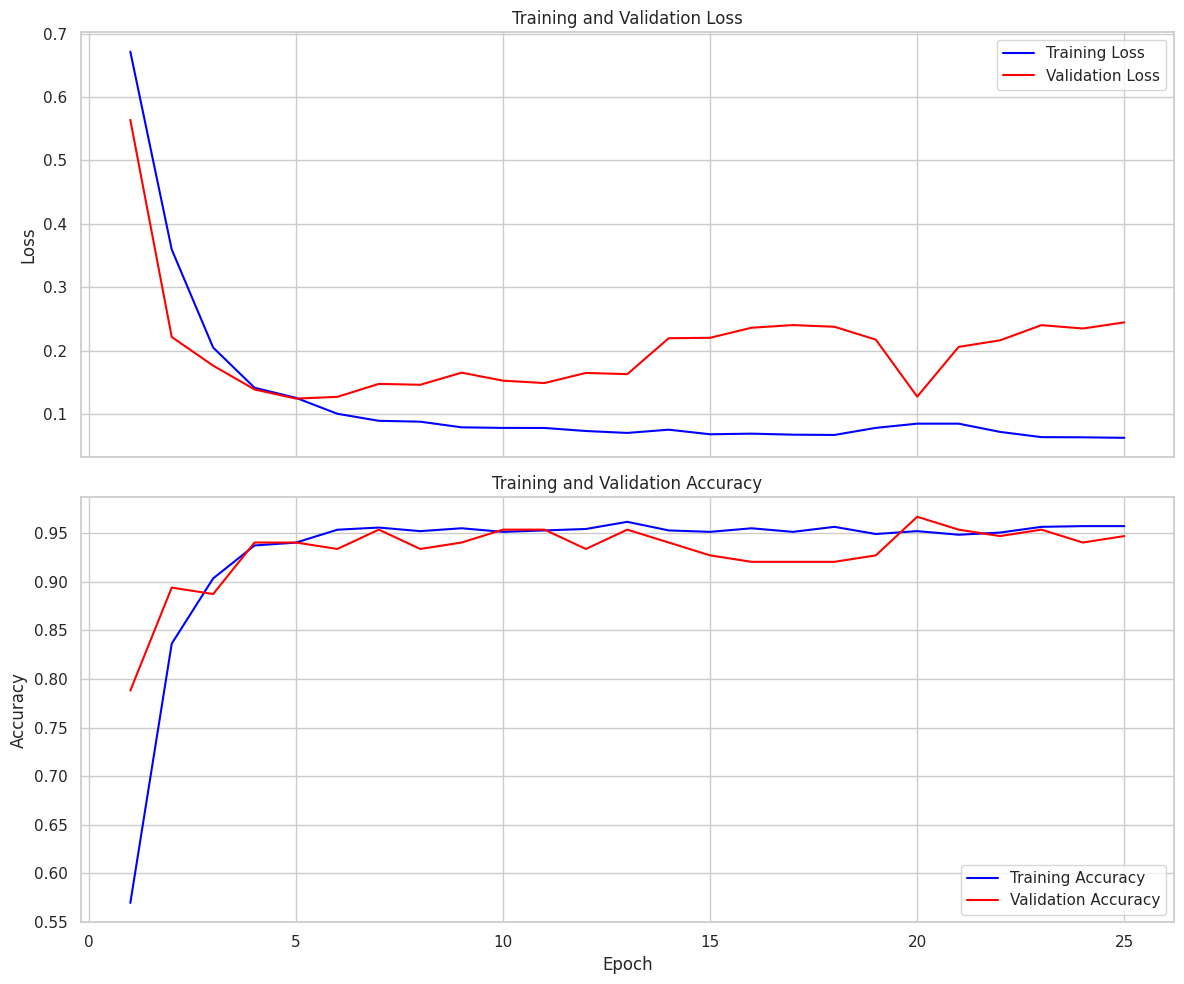

In [10]:

# Extract the history data into a DataFrame
history_df = pd.DataFrame({
    'epoch': range(1, len(history.history['loss']) + 1),
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
})

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot training and validation loss
sns.lineplot(x='epoch', y='loss', data=history_df, label='Training Loss', ax=axs[0], color='blue')
sns.lineplot(x='epoch', y='val_loss', data=history_df, label='Validation Loss', ax=axs[0], color='red')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()

# Find the epoch with the best validation accuracy
best_epoch = history_df['val_accuracy'].idxmax()
best_accuracy = history_df['val_accuracy'].max()

# Plot training and validation accuracy
sns.lineplot(x='epoch', y='accuracy', data=history_df, label='Training Accuracy', ax=axs[1], color='blue')
sns.lineplot(x='epoch', y='val_accuracy', data=history_df, label='Validation Accuracy', ax=axs[1], color='red')

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Model Evaluation: Predictions, Metrics, and Performance Summary

In [11]:
# Predict on test data
y_pred_probs = best_model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype('int32')  # Convert probabilities to binary class predictions

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute average precision, recall, and F1 score
precision_avg = precision_score(y_test, y_pred, average='macro')
recall_avg = recall_score(y_test, y_pred, average='macro')
f1_avg = f1_score(y_test, y_pred, average='macro')

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract true positives, true negatives, false positives, and false negatives
tn, fp, fn, tp = cm.ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Print classification report
print(f'\nClassification Report:\n{classification_report(y_test, y_pred, target_names=["Defective", "Non-Defective"])}')

# Format results in a table-like structure similar to a deep learning paper
table_data = [
    ["Metric", "Value"],
    ["Accuracy", f"{accuracy:.2f}"],
    ["Precision", f"{precision_avg:.2f}"],
    ["Recall", f"{recall_avg:.2f}"],
    ["F1 Score", f"{f1_avg:.2f}"],
    ["True Positives (TP)", tp],
    ["True Negatives (TN)", tn],
    ["False Positives (FP)", fp],
    ["False Negatives (FN)", fn]
]

# Display the results as a table
table_df = pd.DataFrame(table_data, columns=["Metric", "Value"])
table_df.to_csv('results.csv', index=False)
print("\nEvaluation Metrics:")
table_df

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step

Classification Report:
               precision    recall  f1-score   support

    Defective       0.96      0.97      0.97        79
Non-Defective       0.97      0.96      0.97        72

     accuracy                           0.97       151
    macro avg       0.97      0.97      0.97       151
 weighted avg       0.97      0.97      0.97       151


Evaluation Metrics:


,Metric,Value
0,Metric,Value
1,Accuracy,0.97
2,Precision,0.97
3,Recall,0.97
4,F1 Score,0.97
5,True Positives (TP),69
6,True Negatives (TN),77
7,False Positives (FP),2
8,False Negatives (FN),3


# Confusion Matrix

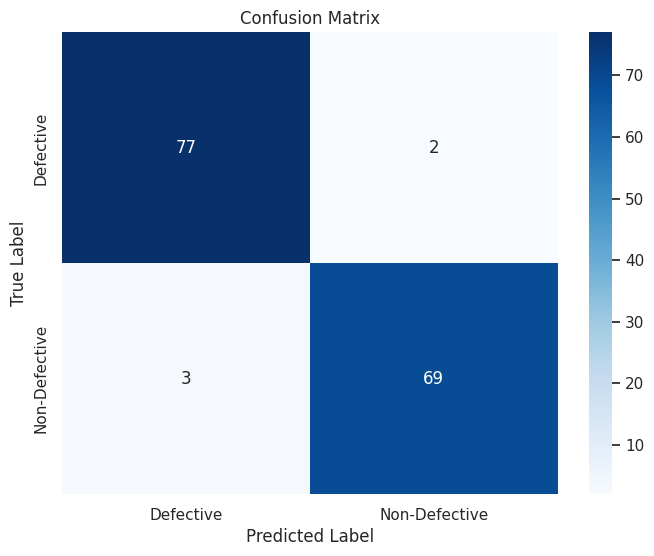

In [13]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Defective', 'Non-Defective'], yticklabels=['Defective', 'Non-Defective'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# ROC Curve

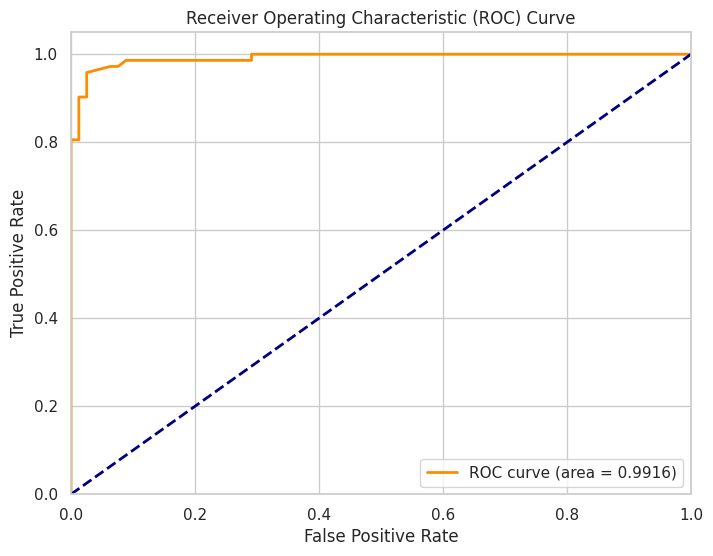

In [14]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Pipeline for Predicting the Class of New C++ Code Using a Trained Model

This code demonstrates how to use a previously trained and saved model to classify new C++ code as either defective or non-defective:

1. **Loading the Best Model**:
   - The best-performing model is loaded from the saved checkpoint file (`checkpoint_filepath`) for making predictions on new data.

2. **Loading the Tokenizer**:
   - The tokenizer used during training is loaded from the `tokenizer.pkl` file. This ensures that the new text is preprocessed consistently with the training data.

3. **New C++ Code Input**:
   - An example of a new C++ code snippet is provided as a string (`new_code`) that needs to be classified.

4. **Text Preprocessing**:
   - The new code is tokenized into a sequence of integers using the loaded tokenizer.
   - The sequence is then padded to match the input length expected by the model (`max_len`), ensuring consistency with the training process.

5. **Prediction**:
   - The preprocessed sequence is fed into the loaded model to predict the probability that the code is non-defective.
   - The probability is converted into a binary label (`0` for defective, `1` for non-defective) based on a threshold of 0.5.

6. **Result Interpretation**:
   - The predicted label is interpreted and printed to inform whether the code is classified as defective or non-defective.


In [15]:
# Load the best model to test it on new text
loaded_model = tf.keras.models.load_model(checkpoint_filepath)

# Load the tokenizer
with open('/content/tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)

# Example of new C++ code to classify
new_code = """
// data_race_example_mpi_openmp.txt
#include <mpi.h>
#include <omp.h>
#include <iostream>
#include <vector>

int main(int argc, char** argv) {
    MPI_Init(&argc, &argv);
    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    std::vector<int> data(100, 0);

    #pragma omp parallel for
    for (int i = 0; i < 100; i++) {
        data[i] += rank;  // Data race: concurrent write to shared vector 'data' by multiple threads
    }

    // Aggregating data across all ranks
    std::vector<int> global_data(100, 0);
    MPI_Allreduce(data.data(), global_data.data(), 100, MPI_INT, MPI_SUM, MPI_COMM_WORLD);

    if (rank == 0) {
        for (int i = 0; i < 100; i++) {
            std::cout << "global_data[" << i << "] = " << global_data[i] << std::endl;
        }
    }

    MPI_Finalize();
    return 0;
}


"""

# Preprocess the text (tokenize and pad)
sequence = loaded_tokenizer.texts_to_sequences([new_code])
padded_sequence = pad_sequences(sequence, maxlen=max_len)

# Predict the label (0 for defective, 1 for non-defective)
prediction = loaded_model.predict(padded_sequence)

# Convert the prediction to a binary label
predicted_label = 1 if prediction >= 0.5 else 0

# Interpret the result
if predicted_label == 1:
    print("The code is classified as non-defective.")
else:
    print("The code is classified as defective.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
The code is classified as defective.
